# **ボストン住宅価格のデータから、価格を予測する機械学習モデルを作る**

データ解析練習用データセットの定番「ボストン住宅価格データ」をExcelにまとめました。

ボストン市内の490件の住宅に対し、
町ごとの犯罪率(CRIM)、雇用センターまでのの距離(DIS)、生徒教師比率(PTRATIO)・・・などなど、

住宅価格に影響しそうな条件と、実際の価格(Price)がまとめられています。

Excelファイルには、シートが２枚あり、

「For ML」シートには、490件の住宅の条件と価格

「For Prediction」シートには、予測したい住宅の条件（価格は未知）
が記載されています。


For MLのデータを元に、住宅価格を予測する機械学習モデルを作り、
For Predictionの条件に対する価格を予測しましょう。


Excelファイルはこちらから取得できます。
https://github.com/hatanaka-lab/Getting_started_with_MI/tree/main/data/Boston.xlsx


In [ ]:
#必要そうなライブラリたちをインポート
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#matplotlibで作成する図の中に日本語のフォントを利用する場合はこちらもインポート
!pip install japanize-matplotlib
import japanize_matplotlib

# **STEP1：データの読み込み**

In [ ]:
# Excelファイルの「For ML」Sheetからﾃﾞｰﾀを読み込んで、dfに代入
# dfは"data frame"の略。
# Pythonでは、"pandas"のdata frameと"numpy"のarrayの2種類をよく使うので、どちらか混乱しないように、data frameにはdfと名前を付ける癖をつけるとよい
df = pd.read_excel("Boston.xlsx", sheet_name='For ML')

In [ ]:
# dfの中身を確認①
# 各列の名前やﾃﾞｰﾀの個数（ぬけがないか等々）をcheck
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       490 non-null    int64  
 1   CRIM     490 non-null    float64
 2   ZN       490 non-null    float64
 3   INDUS    490 non-null    float64
 4   CHAS     490 non-null    int64  
 5   NOX      490 non-null    float64
 6   RM       490 non-null    float64
 7   AGE      490 non-null    float64
 8   DIS      490 non-null    float64
 9   RAD      490 non-null    int64  
 10  TAX      490 non-null    int64  
 11  PTRATIO  490 non-null    float64
 12  B        490 non-null    float64
 13  LSTAT    490 non-null    float64
 14  Price    490 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 57.5 KB


In [ ]:
# df の中身を確認②
# ﾃﾞｰﾀを上から３行だけ見てみる head(#) の#の数で表示する行数を指定
df.head(3)

,No,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


# **STEP2：データを観察**

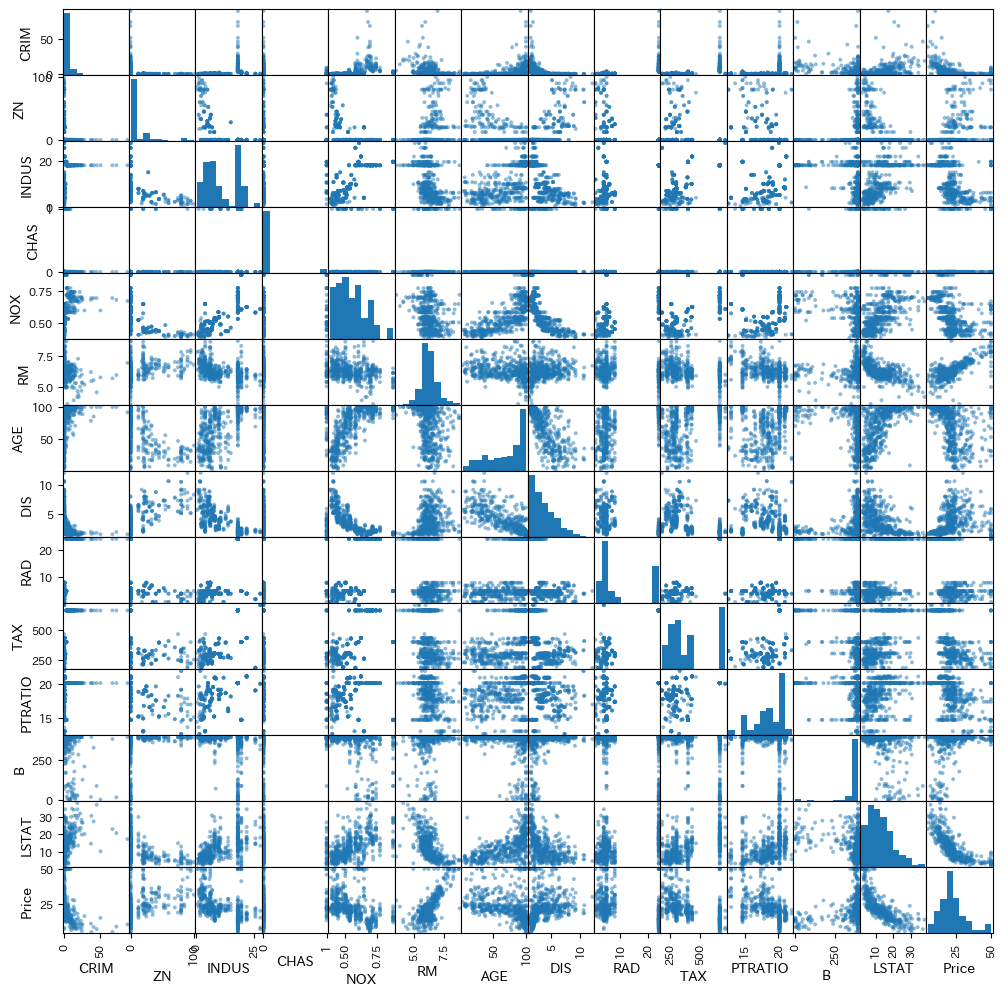

In [ ]:
# データの分布を観察する：その1
df_Target=df.drop(columns=['No'])
pd.plotting.scatter_matrix(df_Target, figsize=(12, 12), hist_kwds={'bins':10},
                           marker=('o'), s=8, alpha=.5)
plt.show()

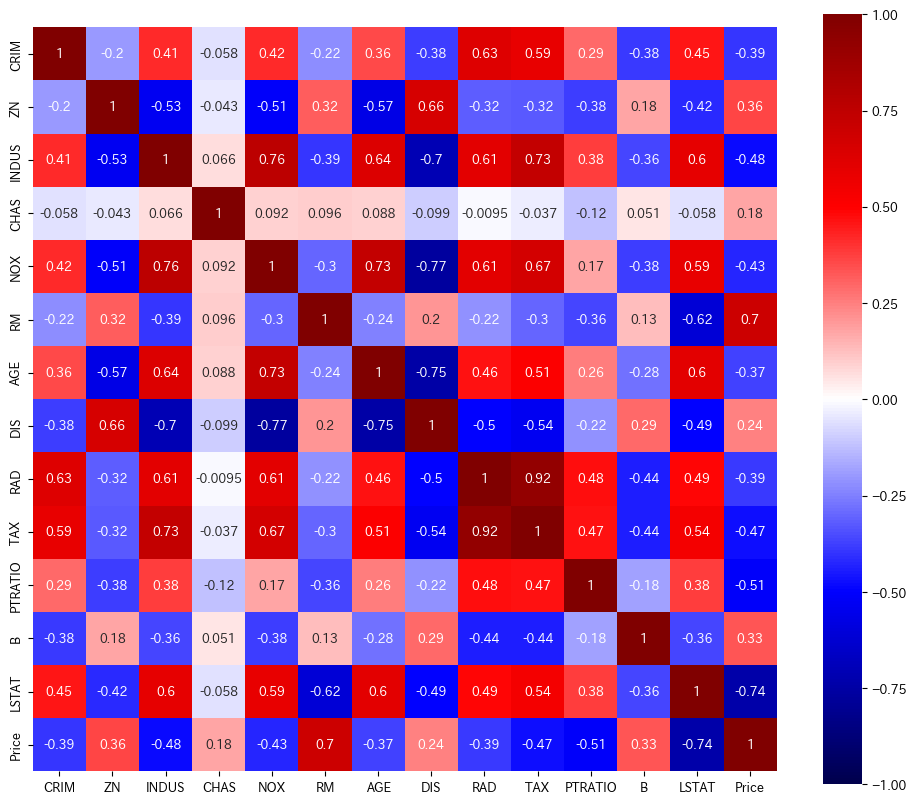

In [ ]:
# データの分布を観察する：その2（相関行列）
correlation_coefficients = df_Target.corr()  # 相関行列の計算
# 相関行列のヒートマップ (相関係数の値あり)
plt.rcParams['font.size'] = 9
plt.figure(figsize=(12, 10))  # この段階で画像のサイズを指定する
sns.heatmap(correlation_coefficients, vmax=1, vmin=-1, cmap='seismic', square=True, annot=True, xticklabels=1, yticklabels=1)
plt.xlim([0, correlation_coefficients.shape[0]])
plt.show()

In [ ]:
# RADと相関の高いTAX特徴量を消去する
df = df.drop(["TAX"], axis=1)

# **STEP3：データを切り分け**

In [ ]:
# dfの1～14列の手前までをXに代入（説明変数に利用）
# 列数は、0からカウント。だから、Noが0列目、CRIMが1列目、LSTATが13行目
X = np.array(df.iloc[:,1:13])
df.iloc[:,1:13].head(2)  #中身の確認用

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,15.3,396.9,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,17.8,396.9,9.14


In [ ]:
# 現在の訓練データXの列名を保持（あとで使用）
X_columns_name = list(df.iloc[:,1:13].columns)
X_columns_name

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'PTRATIO',
 'B',
 'LSTAT']

In [ ]:
# Priceとラベル付けされた列をYに代入（目的変数に利用）
Y = np.array(df["Price"])
df["Price"].head(2)  #中身の確認用

0    24.0
1    21.6
Name: Price, dtype: float64

In [ ]:
#　説明変数を標準化する
#　標準化された値 = (元の値－平均値)/標準偏差
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
# ホールドアウト検証用にﾃﾞｰﾀを　訓練ﾃﾞｰﾀ（train)と検証用ﾃﾞｰﾀ（test）に分ける。
# 分け方はランダム（今回は、train : test = 80% : 20%に分ける）
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2,random_state=999)

# **STEP4：ハイパーパラメタの決定**

In [ ]:
# RandomForest用にハイパーパラメタを決める
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
list_param = []
list_score = []
for ne in range(5,250,50):
  for nd in range(5,41,5):
    model = RandomForestRegressor(n_estimators=ne, max_depth=nd, random_state=555)
    cv5_score = cross_val_score(model, X_train, y_train, cv=5).mean()  #訓練用データ(train)を用いて5-fold CV
    print("num_trees=",ne,"max_depth=",nd,"R2_score=",cv5_score)
    list_param.append([ne,nd])
    list_score.append(cv5_score)
max_index = np.argmax(list_score)
print("")
print("-----Best parameters-----")
print("num_trees=",list_param[max_index][0], "max_depth=",list_param[max_index][1],"R2_score=",list_score[max_index])

num_trees= 5 max_depth= 5 R2_score= 0.7981263402619879
num_trees= 5 max_depth= 10 R2_score= 0.8001995103264792
num_trees= 5 max_depth= 15 R2_score= 0.7965916567538338
num_trees= 5 max_depth= 20 R2_score= 0.7968030184173452
num_trees= 5 max_depth= 25 R2_score= 0.7968030184173452
num_trees= 5 max_depth= 30 R2_score= 0.7968030184173452
num_trees= 5 max_depth= 35 R2_score= 0.7968030184173452
num_trees= 5 max_depth= 40 R2_score= 0.7968030184173452
num_trees= 55 max_depth= 5 R2_score= 0.8059245567136714
num_trees= 55 max_depth= 10 R2_score= 0.8171564184959662
num_trees= 55 max_depth= 15 R2_score= 0.817122737675577
num_trees= 55 max_depth= 20 R2_score= 0.8158341126923963
num_trees= 55 max_depth= 25 R2_score= 0.8158527458204972
num_trees= 55 max_depth= 30 R2_score= 0.8158527458204972
num_trees= 55 max_depth= 35 R2_score= 0.8158527458204972
num_trees= 55 max_depth= 40 R2_score= 0.8158527458204972
num_trees= 105 max_depth= 5 R2_score= 0.8088140812855116
num_trees= 105 max_depth= 10 R2_score= 0.8

# **STEP5：機械学習実行**

この直後に出てくる、RandomForestRegressorの部分を他の機械学習の方法名に置き換えると、色々な方法を試すことができる

In [ ]:
#　機械学習実行
#  Random Forest回帰を採用
#  これを実行すると、「model」の中身が 訓練ﾃﾞｰﾀから作られた機械学習モデルになる
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=list_param[max_index][0],max_depth=list_param[max_index][1],random_state=1)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=155, random_state=1)

In [ ]:
# 機械学習モデルの妥当性を検証
# 訓練ﾃﾞｰﾀとテストデータのスコアを見る　（scoreが1に近い程良いモデル）
print("Score for Training Data:", model.score(X_train,y_train))
print("Score for Test Data    :", model.score(X_test ,y_test ))

Score for Training Data: 0.9781011085416481
Score for Test Data    : 0.8295383352576611


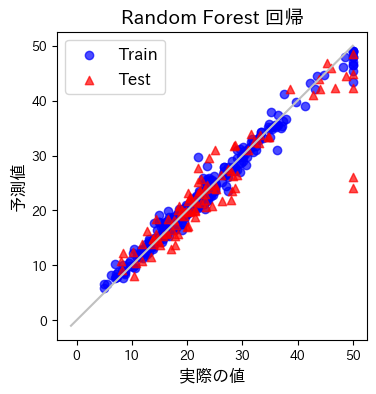

In [ ]:
# 散布図を描く
# 横軸が実際の値(y)：縦軸が機械学習モデルから予測した値
# データが対角線上にある程、予測精度が高いことを意味する
plt.figure(figsize=(4,4))
plt.scatter(y_train,model.predict(X_train),c='b',marker='o',alpha=0.7,label='Train')
plt.scatter(y_test, model.predict(X_test ),c='r',marker='^',alpha=0.7,label='Test')
# 対角線をひく
x1 = np.linspace(-1, 50, 100)
plt.plot(x1, x1, linestyle='-',c="silver")
#
plt.title("Random Forest 回帰", fontsize=14)
plt.ylabel("予測値", fontsize=12)
plt.xlabel("実際の値", fontsize=12)
plt.legend(fontsize=12)
plt.show()

横軸：実際の値、縦軸：機械学習による予測値。データが対角線上にあるほど、予測精度が良いことを示す。

In [ ]:
# Random Forest回帰モデルの特徴量重要度を解析
# まずは表形式（DataFrame型）で出力
model_importances = pd.DataFrame({"importance": model.feature_importances_}, index=X_columns_name)
# 重要度ごとの昇順にして表示
model_importances_sorted = model_importances.sort_values(by="importance", ascending=True)
model_importances_sorted

,importance
CHAS,0.001389
ZN,0.001565
RAD,0.005363
INDUS,0.011174
B,0.013720
AGE,0.016060
PTRATIO,0.019345
DIS,0.034630
NOX,0.034673
CRIM,0.073144


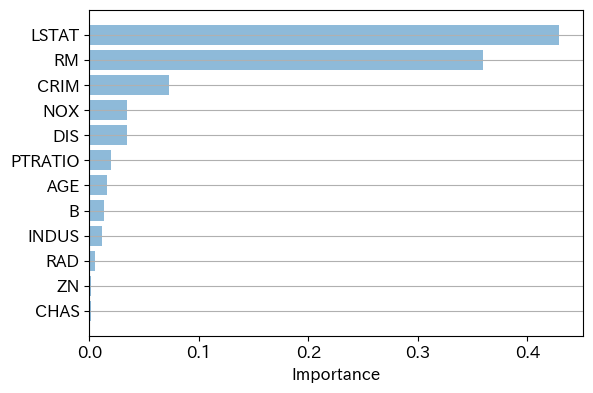

In [ ]:
# 棒グラフで重要度を図示
fig, ax = plt.subplots(figsize=(6,4))
y_pos = np.arange(model_importances_sorted.shape[0])
list_importances = list(model_importances_sorted["importance"])
ax.barh(y_pos, list_importances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_importances_sorted.index)
label_imp_font = {'size':'12'}
title_imp_font = {'size':'12'}
ax.set_xlabel('Importance', fontdict=label_imp_font)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

# **STEP6：住宅価格が未知のデータに対する予測**

In [ ]:
# ここで、Priceの分からない未知のデータの説明変数（X)を読み込む
df_Pred = pd.read_excel("Boston.xlsx", sheet_name='For Prediction')

In [ ]:
# ﾃﾞｰﾀはX_Predに代入
X_Pred = np.array(df_Pred[X_columns_name])
df_Pred[X_columns_name].head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,18.7,394.63,2.94
1,0.62739,0,8.14,0,0.538,5.834,56.5,4.4986,4,21.0,395.62,8.47


In [ ]:
#　説明変数を標準化する
#  機械学習モデルを作った時に定義したscalerをそのまま適用
X_Pred_scaled = scaler.transform(X_Pred)

In [ ]:
#　機械学習モデルに入力して、Priceの値を算出
model.predict(X_Pred_scaled)

array([36.65739222, 20.36473168, 22.36421356, 18.50082701, 20.29098512,
       34.62065724, 45.62193548, 29.61844641, 25.57559342, 15.74569828,
       21.03052136, 26.31399225, 18.85916347, 12.3705273 , 20.8317581 ,
       21.70993072])

In [ ]:
# 上の表記だと、予測したいサンプルが多数ある場合に見にくいので、Excelに書き出す
df_result = pd.DataFrame(model.predict(X_Pred_scaled))
df_summary = pd.concat([df_Pred, df_result], axis=1)
df_summary.to_excel("Boston_result.xlsx")

In [ ]:
# ファイルダウンロード方法①
# Google Colab画面の左側の「ファイル」ボタンをクリック
# Boston_results.xlsxにカーソルを合わせ、右側の「縦に・が3つ並んだマーク」をクリック→ダウンロードをクリック

# ファイルダウンロード方法②
# 下記コードでもダウンロード可能
#from google.colab import files
#downloaded = files.download("Boston_result.xlsx")

ダウンロードファイルの一番右側の列に、予測価格が書き込まれています。

# **おまけ：他の機械学習モデルも色々検討**

例１：PLS回帰

In [ ]:
# RandomForest用にハイパーパラメタを決める
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
list_param = []
list_score = []
for k in range(2,13,1):
  model = PLSRegression(n_components=k)
  cv5_score = cross_val_score(model, X_train, y_train, cv=5).mean()  #訓練用データ(train)を用いて5-fold CV
  print("n_components=", k, "R2_score=", cv5_score)
  list_param.append(k)
  list_score.append(cv5_score)
max_index = np.argmax(list_score)
print("")
print("-----Best parameters-----")
print("n_components=",list_param[max_index],"R2_score=",list_score[max_index])

n_components= 2 R2_score= 0.6961092191627717
n_components= 3 R2_score= 0.7068398174725843
n_components= 4 R2_score= 0.7070442006556428
n_components= 5 R2_score= 0.7094456158531661
n_components= 6 R2_score= 0.7114796541503999
n_components= 7 R2_score= 0.7118112082030241
n_components= 8 R2_score= 0.7121319946311402
n_components= 9 R2_score= 0.7121349549536939
n_components= 10 R2_score= 0.712118852124499
n_components= 11 R2_score= 0.7121120765012157
n_components= 12 R2_score= 0.7121112066637314

-----Best parameters-----
n_components= 9 R2_score= 0.7121349549536939


Score for Training Data: 0.7448949847058128
Score for Test Data    : 0.6863996772622745


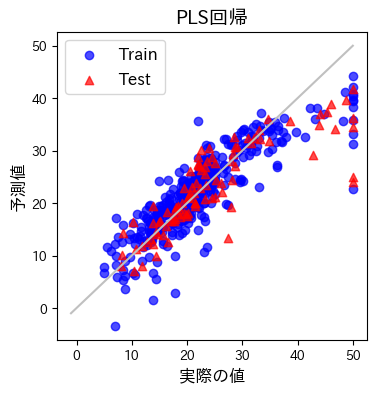

In [ ]:
# 機械学習の方法を選択
# 今回はPLS回帰（個人的にはお気に入り）
from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=list_param[max_index])

# 機械学習実行：ここから後ろは、RandomForestの時と変更なし
model.fit(X_train, y_train)
# 検証
print("Score for Training Data:", model.score(X_train,y_train))
print("Score for Test Data    :", model.score(X_test ,y_test ))
# 散布図描画
plt.figure(figsize=(4,4))
plt.scatter(y_train,model.predict(X_train),c='b',marker='o',alpha=0.7,label='Train')
plt.scatter(y_test, model.predict(X_test ),c='r',marker='^',alpha=0.7,label='Test')
x1 = np.linspace(-1, 50, 100)
plt.plot(x1, x1, linestyle='-',c="silver")
plt.title("PLS回帰", fontsize=14)
plt.ylabel("予測値", fontsize=12)
plt.xlabel("実際の値", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# PLS回帰モデルの特徴量重要度を解析
# まずは表形式（DataFrame型）で出力
model_importances = pd.DataFrame({"importance": model.coef_.flatten()}, index=X_columns_name)
# 重要度ごとの昇順にして表示
model_importances_sorted = model_importances.sort_values(by="importance", ascending=True)
model_importances_sorted

/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


,importance
LSTAT,-3.398649
DIS,-2.988533
NOX,-2.334863
PTRATIO,-2.110445
CRIM,-1.029559
INDUS,-0.396271
AGE,0.057013
CHAS,0.708198
B,0.751044
RAD,0.898164


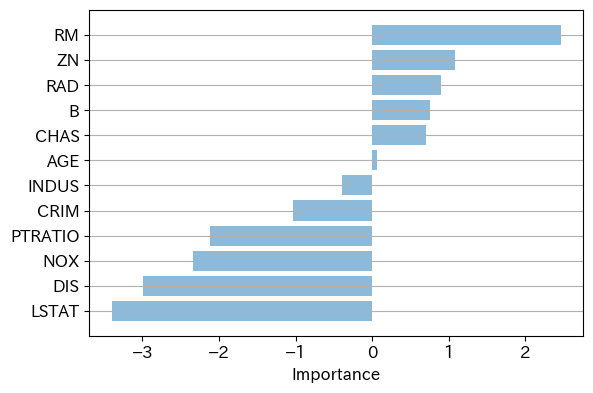

In [ ]:
# 棒グラフで重要度を図示
fig, ax = plt.subplots(figsize=(6,4))
y_pos = np.arange(model_importances_sorted.shape[0])
list_importances = list(model_importances_sorted["importance"])
ax.barh(y_pos, list_importances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_importances_sorted.index)
label_imp_font = {'size':'12'}
title_imp_font = {'size':'12'}
ax.set_xlabel('Importance', fontdict=label_imp_font)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

例２：LASSO回帰

alpha    =  0.040991459107968795
Score for Training Data: 0.7442920227271885
Score for Test Data    : 0.6833227282920873


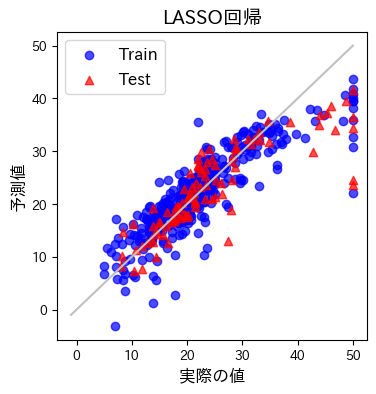

In [ ]:
# 機械学習の方法を選択
# LASSO回帰のハイパーパラメタチューニングと回帰を両方実施（親切♪）
from sklearn.linear_model import LassoCV
model = LassoCV(n_alphas=50, cv=5, max_iter=100000)

# 機械学習実行：ここから後ろは、RandomForestの時と変更なし
model.fit(X_train, y_train)
# 5-fold CVで決めたハイパーパラメタ(α)を表示
print('alpha    = ', model.alpha_)
# 検証
print("Score for Training Data:", model.score(X_train,y_train))
print("Score for Test Data    :", model.score(X_test ,y_test ))
# 散布図描画
plt.figure(figsize=(4,4))
plt.scatter(y_train,model.predict(X_train),c='b',marker='o',alpha=0.7,label='Train')
plt.scatter(y_test, model.predict(X_test ),c='r',marker='^',alpha=0.7,label='Test')
x1 = np.linspace(-1, 50, 100)
plt.plot(x1, x1, linestyle='-',c="silver")
plt.title("LASSO回帰", fontsize=14)
plt.ylabel("予測値", fontsize=12)
plt.xlabel("実際の値", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Lasso回帰モデルの特徴量重要度を解析
# まずは表形式（DataFrame型）で出力
model_importances = pd.DataFrame({"importance": model.coef_}, index=X_columns_name)
# 重要度ごとの昇順にして表示
model_importances_sorted = model_importances.sort_values(by="importance", ascending=True)
model_importances_sorted

,importance
LSTAT,-3.324883
DIS,-2.786074
NOX,-2.141843
PTRATIO,-2.022086
CRIM,-0.858851
INDUS,-0.299884
AGE,0.000000
CHAS,0.651715
RAD,0.668573
B,0.711010


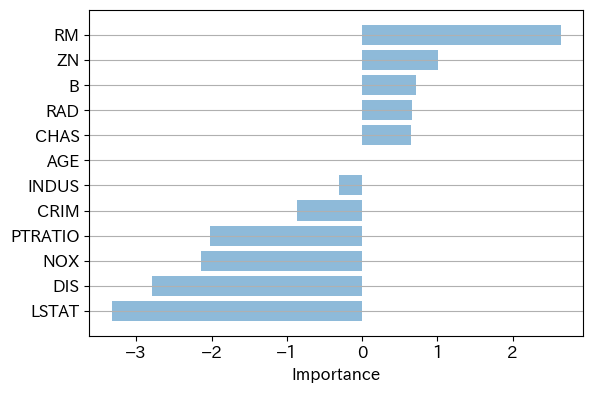

In [ ]:
# 棒グラフで重要度を図示
fig, ax = plt.subplots(figsize=(6,4))
y_pos = np.arange(model_importances_sorted.shape[0])
list_importances = list(model_importances_sorted["importance"])
ax.barh(y_pos, list_importances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_importances_sorted.index)
label_imp_font = {'size':'12'}
title_imp_font = {'size':'12'}
ax.set_xlabel('Importance', fontdict=label_imp_font)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()